In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.signal import savgol_filter
from lmfit import Minimizer, Parameters, create_params, report_fit, Model
import os
import sys
sys.path.append('../src')
import json

## load rho(r) data from phaselift

In [2]:
filename = "./rho.txt"
data = np.loadtxt(filename)
r = data[:, 0]
rho = data[:, 1:]

filename_err = "./rho_err_SEQ.txt"
data_err = np.loadtxt(filename_err)
r_err = data_err[:, 0]
rho_err = data_err[:, 1:]

## plot loaded data

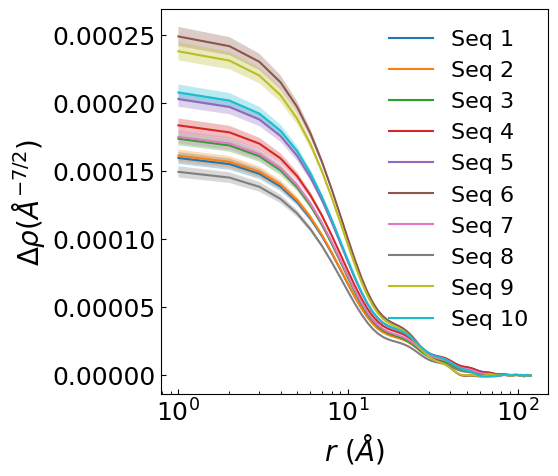

In [3]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

n_seq = rho.shape[1]
for i in range(n_seq):
    ax.plot(r, rho[:, i], '-', label=f'Seq {i+1}')
    ax.fill_between(r, rho[:, i] - rho_err[:, i], rho[:, i] + rho_err[:, i], alpha=0.3)

ax.set_xscale('log')
ax.set_xlabel(r'$r\ (\AA)$', fontsize=20)
ax.set_ylabel(r'$\Delta\rho (\AA^{-7/2})$', fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax.legend(fontsize=16, frameon=False)

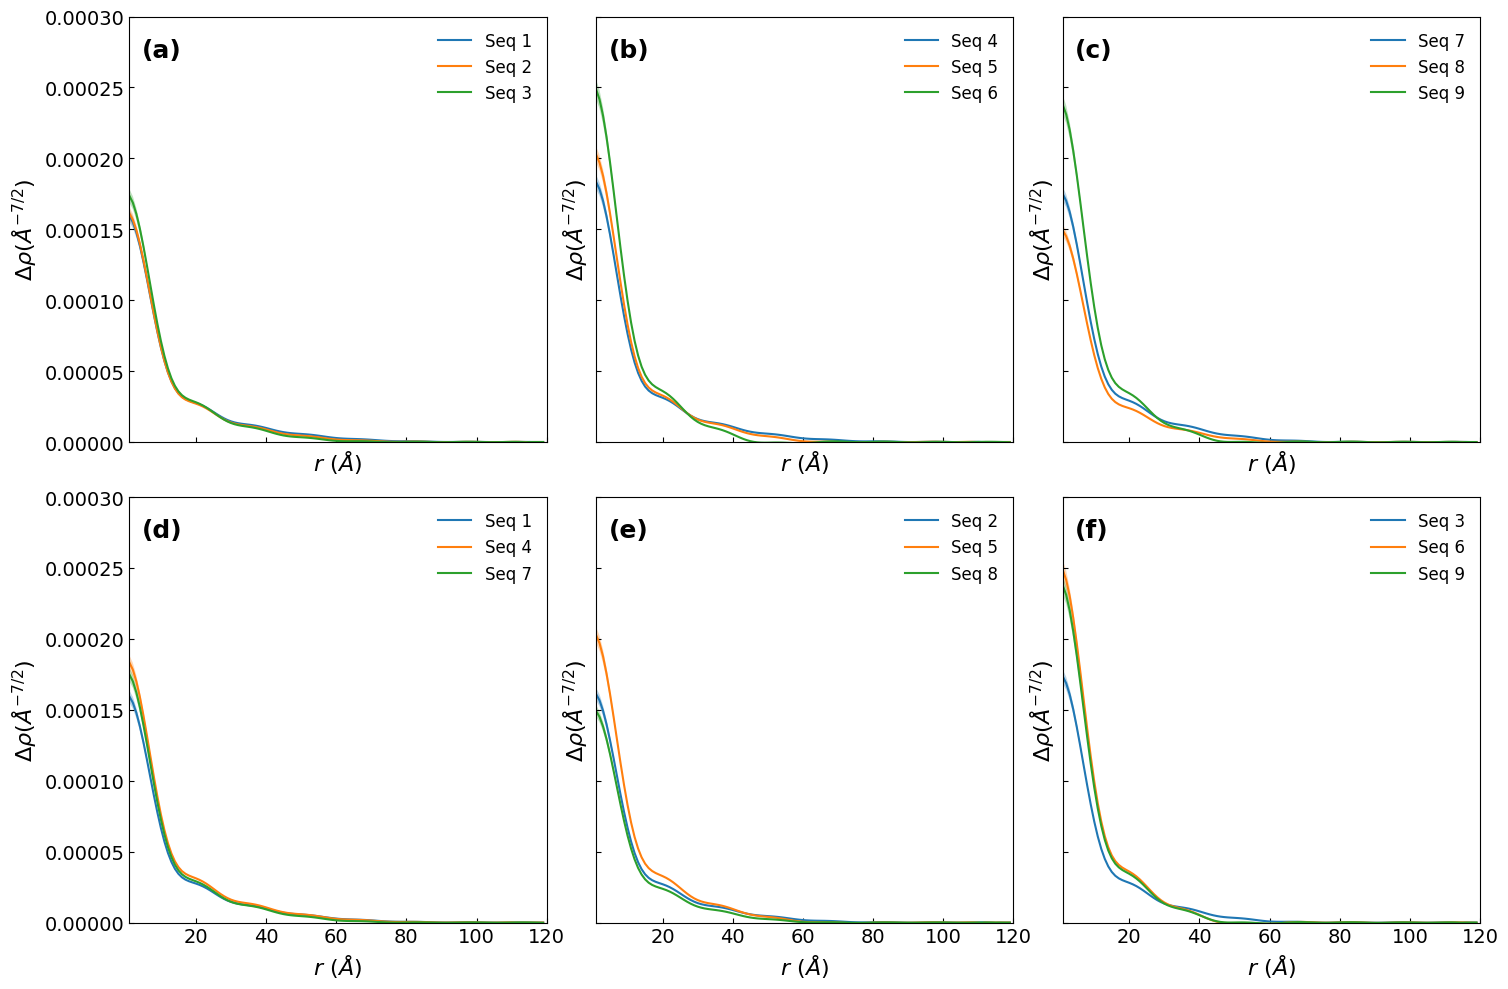

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Panel labels
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for ax, label in zip(axes.flat, panel_labels):
    ax.text(0.03, 0.95, label, transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

# First row: groups 1-2-3, 4-5-6, 7-8-9
groups_row1 = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
for col, group in enumerate(groups_row1):
    ax = axes[0, col]
    for idx in group:
        ax.plot(r, rho[:, idx], '-', label=f'Seq {idx+1}')
        ax.fill_between(r, rho[:, idx] - rho_err[:, idx], rho[:, idx] + rho_err[:, idx], alpha=0.3)
    # ax.set_xscale('log')
    ax.set_xlabel(r'$r\ (\AA)$', fontsize=16)
    ax.set_ylabel(r'$\Delta\rho (\AA^{-7/2})$', fontsize=16)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=14)
    ax.legend(fontsize=12, frameon=False)
    ax.set_ylim([0, 0.0003])
    ax.set_xlim([1, 120])  # Set x-limits for better visibility

# Second row: groups 1-4-7, 2-5-8, 3-6-9
groups_row2 = [[0, 3, 6], [1, 4, 7], [2, 5, 8]]
for col, group in enumerate(groups_row2):
    ax = axes[1, col]
    for idx in group:
        ax.plot(r, rho[:, idx], '-', label=f'Seq {idx+1}')
        ax.fill_between(r, rho[:, idx] - rho_err[:, idx], rho[:, idx] + rho_err[:, idx], alpha=0.3)
    # ax.set_xscale('log')
    ax.set_xlabel(r'$r\ (\AA)$', fontsize=16)
    ax.set_ylabel(r'$\Delta\rho (\AA^{-7/2})$', fontsize=16)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=14)
    ax.legend(fontsize=12, frameon=False)
    ax.set_ylim([0, 0.0003])  # Adjust y-limits for better visibility
    ax.set_xlim([1, 120])

plt.tight_layout()

## evaluate the uniform ball radius

In [5]:
R_uniform_list = []
V_list = []
for i in range(rho.shape[1]):
    rho_i = rho[:, i]
    # rho_i0 = rho_i[0]
    # Perform a quadratic fit using the first 4 points
    coeffs = np.polyfit(r[:4], rho_i[:4], 2)
    # Evaluate the quadratic polynomial at r=0 to determine rho_i0
    rho_i0 = np.polyval(coeffs, 0)
    
    integral_rho_i = np.trapz(rho_i * 4 * np.pi * r**2, r) # int rho(r)*4pi*r^2*dr
    V = integral_rho_i / rho_i0 # V = int rho(r)*4pi*r^2*dr / rho(0)
    R_uniform = (3 * V / (4 * np.pi))**(1/3) # R_uniform = (3 * V / (4 * np.pi))**(1/3)
    
    R_uniform_list.append(R_uniform)
    V_list.append(V)
R_uniform_list = np.array(R_uniform_list)
V_list = np.array(V_list)

R_uniform_err_list = []
V_err_list = []
for i in range(rho.shape[1]):
    rho_i = rho[:, i]
    rho_err_i = rho_err[:, i]
    # Quadratic fit for rho_i0
    coeffs = np.polyfit(r[:4], rho_i[:4], 2)
    coeffs_err = np.polyfit(r[:4], rho_err_i[:4], 2)
    rho_i0 = np.polyval(coeffs, 0)
    rho_i0_err = np.polyval(coeffs_err, 0)
    
    integral_rho_i = np.trapz(rho_i * 4 * np.pi * r**2, r)
    integral_rho_err = np.trapz(rho_err_i * 4 * np.pi * r**2, r)
    
    V = integral_rho_i / rho_i0
    # Error propagation for V = A/B: (dV/V)^2 = (dA/A)^2 + (dB/B)^2
    V_err = V * np.sqrt((integral_rho_err / integral_rho_i)**2 + (rho_i0_err / rho_i0)**2)
    V_err_list.append(V_err)
    
    # Error propagation for R = (3V/4pi)^(1/3)
    R_uniform = R_uniform_list[i]
    R_uniform_err = (1/3) * R_uniform * (V_err / V)
    R_uniform_err_list.append(R_uniform_err)
R_uniform_err_list = np.array(R_uniform_err_list)
V_err_list = np.array(V_err_list)

for i in range(len(R_uniform_list)):
    print(f"Seq {i+1}: R = {R_uniform_list[i]:.3f} ± {R_uniform_err_list[i]:.3f}")

Seq 1: R = 25.008 ± 0.244
Seq 2: R = 23.170 ± 0.240
Seq 3: R = 21.263 ± 0.234
Seq 4: R = 24.142 ± 0.240
Seq 5: R = 20.910 ± 0.236
Seq 6: R = 17.319 ± 0.233
Seq 7: R = 22.593 ± 0.230
Seq 8: R = 20.577 ± 0.227
Seq 9: R = 17.461 ± 0.239
Seq 10: R = 19.953 ± 0.240


## evaluate radius of gyration

In [6]:
R_g_list = []
for i in range(rho.shape[1]):
    rho_i = rho[:, i]
    rho_i0 = rho_i[0]
    
    # Calculate the radius of gyration
    R_g = np.sqrt(np.trapz(rho_i * 4 * np.pi * r**2 * (r)**2, r) / np.trapz(rho_i * 4 * np.pi * r**2, r))
    R_g_list.append(R_g)
R_g_list = np.array(R_g_list)

R_g_err_list = []
for i in range(rho.shape[1]):
    rho_i = rho[:, i]
    rho_err_i = rho_err[:, i]
    rho_i0 = rho_i[0]
    rho_i0_err = rho_err_i[0]
    
    integral_num = np.trapz(rho_i * 4 * np.pi * r**2 * (r)**2, r)
    integral_num_err = np.trapz(rho_err_i * 4 * np.pi * r**2 * (r)**2, r)
    
    integral_den = np.trapz(rho_i * 4 * np.pi * r**2, r)
    integral_den_err = np.trapz(rho_err_i * 4 * np.pi * r**2, r)
    
    R_g = R_g_list[i]
    
    # Error propagation for R_g = sqrt(A/B): (dR_g/R_g)^2 = (1/4)(dA/A)^2 + (1/4)(dB/B)^2
    R_g_err = (1/2) * R_g * np.sqrt((integral_num_err / integral_num)**2 + (integral_den_err / integral_den)**2)
    R_g_err_list.append(R_g_err)
R_g_err_list = np.array(R_g_err_list)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$R (\\AA)$')

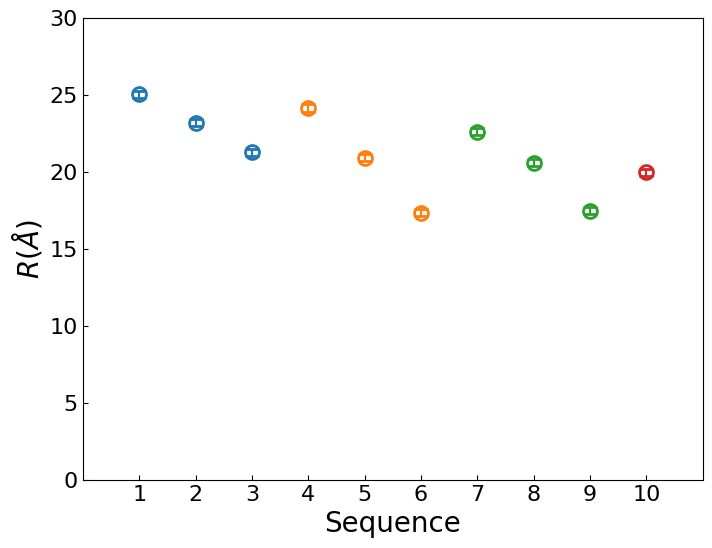

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

xlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
colors = ['C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3']

for i in range(10):
    ax.errorbar(i, R_uniform_list[i], yerr=R_uniform_err_list[i], fmt='o', color=colors[i], markersize=10, markeredgewidth=2, capsize=5, fillstyle='none')

ax.set_xlim([-1, 10])
ax.set_ylim([0, 30])
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xlabels, fontsize=14)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.legend(fontsize=16, frameon=False)
ax.set_xlabel(r'Sequence', fontsize=20)
ax.set_ylabel(r'$R (\AA)$', fontsize=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$R_g (\\AA)$')

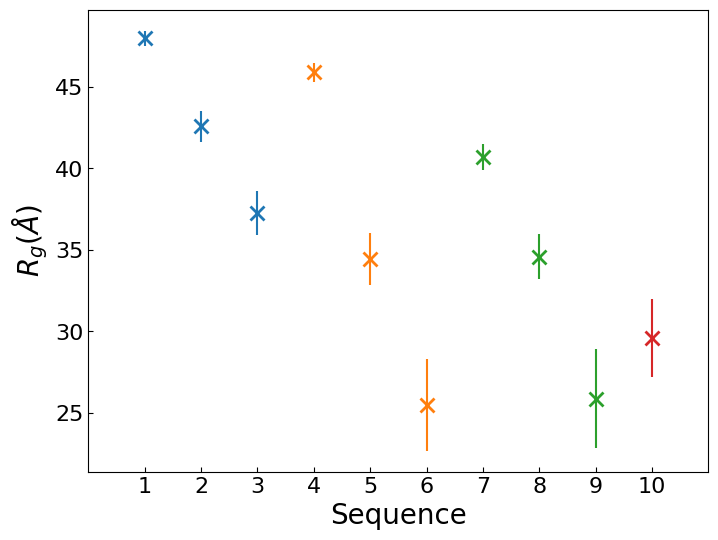

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

xlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
colors = ['C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3']

for i in range(10):
    ax.errorbar(i, R_g_list[i], yerr=R_g_err_list[i], fmt='x', color=colors[i], markersize=10, markeredgewidth=2)

ax.set_xlim([-1, 10])
# ax.set_ylim([0, 30])
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xlabels, fontsize=14)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.legend(fontsize=16, frameon=False)
ax.set_xlabel(r'Sequence', fontsize=20)
ax.set_ylabel(r'$R_g (\AA)$', fontsize=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$V (\\mathrm{nm}^3)$')

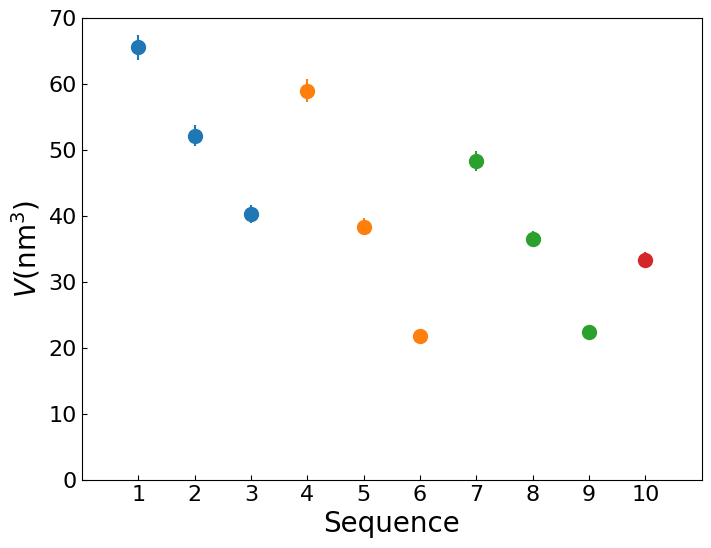

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

xlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
colors = ['C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3']

for i in range(10):
    ax.errorbar(i, V_list[i]/1000, yerr=V_err_list[i]/1000, fmt='o', color=colors[i], markersize=10)

ax.set_xlim([-1, 10])
ax.set_ylim([0, 70])
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xlabels, fontsize=14)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.legend(fontsize=16, frameon=False)
ax.set_xlabel(r'Sequence', fontsize=20)
ax.set_ylabel(r'$V (\mathrm{nm}^3)$', fontsize=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$N_\\mathrm{Agg}$')

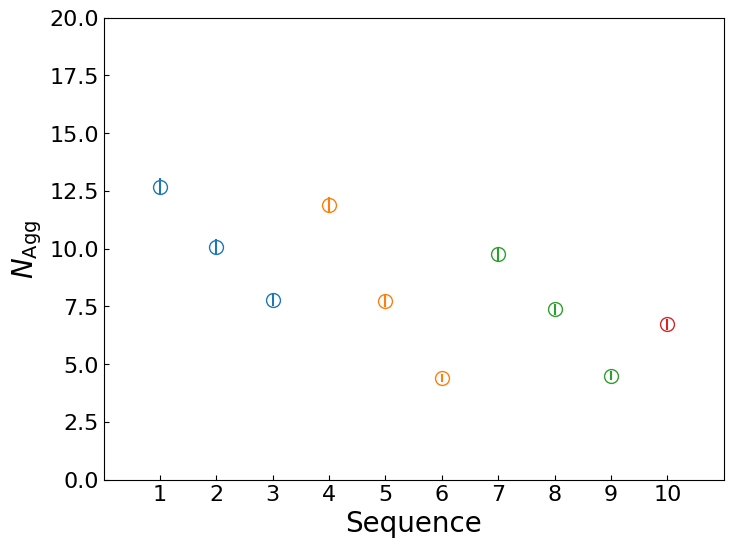

In [10]:
density_sgl = 1.08 # g/cm^3
density_tri = 1.06 # g/cm^3

mC = 12.01 # g/mol
mH = 1.008 # g/mol
mN = 14.01 # g/mol
mO = 16.00 # g/mol

m_sgl = ((mC + mH*3 + mC + mO)
    + (mN + (mC*10 + mH*21) + mC + mH*2 + mC + mO)*5
    + (mN + (mC*2 + mH*4 + mO + mC + mH*3) + mC + mH*2 + mC + mO)*19
    + (mN + mC*3 + mH*4 + mO*2) + mC + mH*2 + mC + mO + (mN + mH*2)*1
       )
m_tri = ((mC + mH*3 + mC + mO)
    + (mN + (mC*10 + mH*21) + mC + mH*2 + mC + mO)*5
    + (mN + (mC*2 + mH*4 + mO + mC + mH*3) + mC + mH*2 + mC + mO)*17
    + (mN + mC*3 + mH*4 + mO*2) + mC + mH*2 + mC + mO + (mN + mH*2)*3
       )

Na = 6.022e23  # Avogadro's number in mol^-1

# Calculate volume per molecule according to density and molar mass
# Volume per molecule (cm^3) = molar mass / (Na * density)
V_sgl = m_sgl / (Na * density_sgl)
V_tri = m_tri / (Na * density_tri)

# Convert to nm^3
V_sgl_nm3 = V_sgl * 1e21
V_tri_nm3 = V_tri * 1e21

v_seq = [V_sgl_nm3, V_sgl_nm3, V_sgl_nm3, V_tri_nm3, V_tri_nm3, V_tri_nm3, V_tri_nm3, V_tri_nm3, V_tri_nm3, V_tri_nm3]

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

xlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
colors = ['C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3']

for i in range(10):
    ax.errorbar(i, V_list[i]/1000/v_seq[i], yerr=V_err_list[i]/1000/v_seq[i], fmt='o', color=colors[i], markersize=10, fillstyle='none')

ax.set_xlim([-1, 10])
ax.set_ylim([0, 20])
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xlabels, fontsize=14)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.legend(fontsize=16, frameon=False)
ax.set_xlabel(r'Sequence', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{Agg}$', fontsize=20)

In [11]:
# Print R, R_err, Rg, Rg_err, Nagg, Nagg_err, and sqrt(5*Rg^2/3R^2) for each sequence
for i in range(len(R_uniform_list)):
    R = R_uniform_list[i]
    R_err = R_uniform_err_list[i]
    Rg = R_g_list[i]
    Rg_err = R_g_err_list[i]
    V_nm3 = V_list[i] / 1000
    V_err_nm3 = V_err_list[i] / 1000
    Nagg = V_nm3 / v_seq[i]
    Nagg_err = Nagg * np.sqrt((V_err_nm3 / V_nm3)**2)
    ratio = np.sqrt(5 * Rg**2 / (3 * R**2))
    print(f"Seq {i+1}: R = {R:.3f} ± {R_err:.3f}, Rg = {Rg:.3f} ± {Rg_err:.3f}, Nagg = {Nagg:.2f} ± {Nagg_err:.2f}, sqrt(5Rg^2/3R^2) = {ratio:.3f}")

Seq 1: R = 25.008 ± 0.244, Rg = 47.972 ± 0.485, Nagg = 12.68 ± 0.37, sqrt(5Rg^2/3R^2) = 2.476
Seq 2: R = 23.170 ± 0.240, Rg = 42.585 ± 0.948, Nagg = 10.08 ± 0.31, sqrt(5Rg^2/3R^2) = 2.373
Seq 3: R = 21.263 ± 0.234, Rg = 37.278 ± 1.340, Nagg = 7.79 ± 0.26, sqrt(5Rg^2/3R^2) = 2.263
Seq 4: R = 24.142 ± 0.240, Rg = 45.900 ± 0.588, Nagg = 11.89 ± 0.36, sqrt(5Rg^2/3R^2) = 2.455
Seq 5: R = 20.910 ± 0.236, Rg = 34.451 ± 1.571, Nagg = 7.73 ± 0.26, sqrt(5Rg^2/3R^2) = 2.127
Seq 6: R = 17.319 ± 0.233, Rg = 25.513 ± 2.817, Nagg = 4.39 ± 0.18, sqrt(5Rg^2/3R^2) = 1.902
Seq 7: R = 22.593 ± 0.230, Rg = 40.729 ± 0.795, Nagg = 9.75 ± 0.30, sqrt(5Rg^2/3R^2) = 2.327
Seq 8: R = 20.577 ± 0.227, Rg = 34.582 ± 1.384, Nagg = 7.37 ± 0.24, sqrt(5Rg^2/3R^2) = 2.170
Seq 9: R = 17.461 ± 0.239, Rg = 25.870 ± 3.046, Nagg = 4.50 ± 0.18, sqrt(5Rg^2/3R^2) = 1.913
Seq 10: R = 19.953 ± 0.240, Rg = 29.589 ± 2.408, Nagg = 6.71 ± 0.24, sqrt(5Rg^2/3R^2) = 1.914
